# Duration of Sick Notes and Associated Diagnoses

This notebook provides descriptive statistics (mean and median) of the duration of sick notes and compares diagnoses associated with sick notes across COVID and comparator cohorts.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns

from functools import reduce
from glob import glob

pd.options.mode.chained_assignment = None

In [2]:
# Function to parse string
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

In [3]:
# Read in and append input files
li = []

for file in glob('../output/cohorts/cohort_rates*.dta'):
    df_temp = pd.read_stata(file)
    # Creates date variable based on file name
    df_temp['cohort'] = file[find_nth(file, '_', 2)+1:-4]
    # Create population count
    df_temp['population'] = 1
    li.append(df_temp)
    
df_temp = pd.concat(li, axis=0, ignore_index=False).reset_index(drop=True)

# hospitalised COVID cohort
covid_hosp = df_temp.loc[(~df_temp.hosp_expo_date.isna()) & (df_temp.cohort == 'covid_2020')]
covid_hosp.cohort = 'covid_hosp_2020'
li.append(covid_hosp)

df_input = pd.concat(li, axis=0, ignore_index=False).reset_index(drop=True)

In [4]:
# Do not count those who had sick notes beyond end dates
df_input.loc[df_input.sick_note == 0, 'first_sick_note_duration'] = np.nan

In [5]:
# Columns to subset
diag_cols = [col for col in df_input if col.startswith('diag_')]
subset_cols = ['cohort','age_group','sex',
               'ethnicity','imd','region_string',
               'first_sick_note_duration',
               'sick_note','population'] + diag_cols

# Subset to relevant columns and do not count those beyond 
df_clean = df_input[subset_cols].rename(columns={'region_string':'region'})

_____

## Duration

In [6]:
def compute_med_mean(path, demo=''):
    groups = ['cohort']
    if demo != '': 
        groups = ['cohort', demo]
    df_pct_ct = df_clean.groupby(
        groups)[['sick_note','population']].sum().reset_index()
    df_med = df_clean.groupby(
        groups)[['first_sick_note_duration']].apply(np.nanmedian).reset_index().rename(columns={0:'median_duration'})
    df_mean = df_clean.groupby(
        groups)[['first_sick_note_duration']].apply(np.nanmean).reset_index().rename(columns={0:'mean_duration'})
    df_pct25 = df_clean.groupby(
        groups)[['first_sick_note_duration']].apply(lambda x: np.nanpercentile(x,25)).reset_index().rename(columns={0:'pct_25'})
    df_pct75 = df_clean.groupby(
        groups)[['first_sick_note_duration']].apply(lambda x: np.nanpercentile(x,75)).reset_index().rename(columns={0:'pct_75'})
    dfs = [df_pct_ct, df_med, df_mean, df_pct25, df_pct75]
    df_out = reduce(
        lambda left,right: pd.merge(left,right,on=groups), dfs
    )
    # Redact if sick notes or population count <= 5 
    df_out = df_out.loc[(df_out['population'] > 5) & (df_out['sick_note'] > 5)]
    Path("../output/tabfig/").mkdir(parents=True, exist_ok=True)
    df_out.to_csv('../output/tabfig/' + path + '.csv', index=False)
    return df_out

In [7]:
# Overall
compute_med_mean('med_mean_overall')

,cohort,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,covid_2020,688.0,1294,267.0,269.031977,212.00,314.25
1,covid_hosp_2020,268.0,498,271.5,268.111940,209.00,310.00
2,general_2019,395.0,867,272.0,280.365482,224.00,322.00
3,general_2020,514.0,860,267.0,271.988327,221.25,319.75
4,pneumonia_2019,194.0,471,272.0,277.314433,223.25,326.00


In [8]:
# Age group
compute_med_mean('med_mean_age_group', 'age_group')

,cohort,age_group,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,covid_2020,0-17,58.0,113,276.0,283.620690,229.25,330.25
1,covid_2020,18-24,61.0,130,265.0,268.426230,206.00,299.00
2,covid_2020,25-34,64.0,135,266.0,271.390625,215.25,298.75
3,covid_2020,35-44,71.0,134,259.0,262.915493,202.50,316.00
4,covid_2020,45-54,152.0,278,264.0,264.802632,209.75,313.25
5,covid_2020,55-69,144.0,263,278.0,279.409722,222.75,319.25
6,covid_2020,70-79,54.0,110,279.5,274.851852,233.25,338.00
7,covid_2020,80+,84.0,131,255.5,248.892857,178.00,307.50
8,covid_hosp_2020,0-17,29.0,54,279.0,283.689655,229.00,333.00
9,covid_hosp_2020,18-24,27.0,54,267.0,286.777778,206.50,287.50


In [9]:
# Sex
compute_med_mean('med_mean_sex', 'sex')

,cohort,sex,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,covid_2020,F,349.0,682,267.0,273.813754,212.00,320.0
1,covid_2020,M,339.0,612,265.0,264.109145,211.50,310.0
2,covid_hosp_2020,F,125.0,253,261.0,264.864000,201.00,302.0
3,covid_hosp_2020,M,143.0,245,277.0,270.951049,225.00,311.5
4,general_2019,F,212.0,449,273.5,287.066038,228.75,322.0
5,general_2019,M,183.0,418,268.0,272.560440,221.00,317.0
6,general_2020,F,271.0,444,270.0,275.202952,229.50,320.0
7,general_2020,M,243.0,416,265.0,268.403292,211.50,319.0
8,pneumonia_2019,F,97.0,230,272.0,281.195876,215.00,330.0
9,pneumonia_2019,M,97.0,241,274.0,273.432990,228.00,315.0


In [10]:
# Ethnicity
compute_med_mean('med_mean_ethnicity', 'ethnicity')

,cohort,ethnicity,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,covid_2020,White,410.0,770,272.0,267.929268,208.25,317.00
1,covid_2020,Asian or Asian British,55.0,109,261.0,259.090909,203.00,298.00
2,covid_2020,Other,45.0,86,255.0,254.888889,219.00,287.00
3,covid_2020,Unknown,178.0,329,265.0,278.219101,215.50,313.00
4,covid_hosp_2020,White,153.0,293,275.0,264.686275,203.00,310.00
5,covid_hosp_2020,Asian or Asian British,23.0,41,253.0,239.695652,198.50,289.50
6,covid_hosp_2020,Other,13.0,28,249.0,212.461538,203.00,273.00
7,covid_hosp_2020,Unknown,79.0,136,269.0,292.177215,227.00,332.00
8,general_2019,White,241.0,528,279.0,286.082988,236.00,323.00
9,general_2019,Asian or Asian British,24.0,67,255.0,256.583333,227.00,281.75


In [11]:
# IMD
compute_med_mean('med_mean_imd', 'imd')

,cohort,imd,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,covid_2020,0,36.0,80,240.5,244.444444,185.25,309.50
1,covid_2020,1,131.0,220,284.0,277.732824,235.50,329.00
2,covid_2020,2,141.0,246,269.0,265.226950,209.00,313.00
3,covid_2020,3,119.0,250,260.0,260.336134,204.50,300.50
4,covid_2020,4,117.0,232,265.0,270.683761,201.00,308.00
5,covid_2020,5,144.0,266,270.0,276.833333,219.25,335.75
6,covid_hosp_2020,0,9.0,20,245.0,260.666667,230.00,289.00
7,covid_hosp_2020,1,62.0,98,288.0,275.064516,228.50,318.50
8,covid_hosp_2020,2,51.0,90,267.0,278.274510,209.00,307.50
9,covid_hosp_2020,3,44.0,92,254.0,253.772727,181.75,303.75


In [12]:
# Region
compute_med_mean('med_mean_region', 'region')

,cohort,region,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,covid_2020,East,70.0,128,278.0,285.414286,225.75,317.50
1,covid_2020,East Midlands,66.0,116,260.0,264.393939,213.25,310.75
2,covid_2020,London,134.0,265,266.5,265.694030,211.50,312.75
3,covid_2020,North East,67.0,130,261.0,282.029851,212.50,354.00
4,covid_2020,North West,71.0,132,274.0,262.239437,223.00,309.50
5,covid_2020,South East,62.0,113,288.0,280.483871,234.25,328.25
6,covid_2020,South West,75.0,138,252.0,252.333333,208.50,298.00
7,covid_2020,West Midlands,75.0,134,275.0,276.373333,212.00,311.00
8,covid_2020,Yorkshire and The Humber,68.0,138,267.5,257.411765,191.00,316.25
9,covid_hosp_2020,East,29.0,54,272.0,300.793103,237.00,301.00


_______

## Associated Diagnoses

In [13]:
def create_plot(measure, ylabel):
    # Create barplot
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(x='cohort', y=measure, data=df_diag_sum, ax=ax)
    # Set title and axes labels
    title = measure[9:].replace("_", " ").title()
    ax.set_title(title)
    ax.set_xlabel('Cohort')
    ax.set_ylabel(ylabel)
    plt.show()
    Path("../output/tabfig/").mkdir(parents=True, exist_ok=True)
    fig.savefig('../output/tabfig/' + measure + '.png')

In [14]:
# Create flag
for c in diag_cols:
    df_clean.loc[~df_clean[c].isna(), 'num_' + c] = 1

# Sum sick notes and diagnoses by cohort
num_diag_cols = [col for col in df_clean if col.startswith('num_diag_')]
diag_subset_cols = ['cohort', 'sick_note'] + num_diag_cols
df_diag = df_clean[diag_subset_cols]
df_diag_sum = df_diag.groupby('cohort').sum().reset_index()

# Proportion of sick notes by diagnoses
for c in num_diag_cols:
    # Redact if <= 5 in sick note or diagnosis count
    df_diag_sum = df_diag_sum.loc[(df_diag_sum['sick_note'] > 5) & (df_diag_sum[c] > 5)]
    df_diag_sum['pct_diag_' + c[9:]] = (df_diag_sum[c]/df_diag_sum['sick_note'])*100
pct_cols = [col for col in df_diag_sum if col.startswith('pct_diag_')]

In [15]:
df_diag_sum

,cohort,sick_note,num_diag_central_nervous_system,num_diag_pregnancy_complication,num_diag_congenital_disease,num_diag_auditory_disorder,num_diag_cardio_disorder,num_diag_bloodcell_disorder,num_diag_connective_tissue,num_diag_digestive_disorder,...,pct_diag_skin_disorder,pct_diag_genitourinary_disorder,pct_diag_infectious_disease,pct_diag_mental_disorder,pct_diag_metabolic_disease,pct_diag_neoplastic_disease,pct_diag_nutritional_disorder,pct_diag_poisoning,pct_diag_trauma,pct_diag_visual_disorder
0,covid_2020,688.0,65.0,72.0,60.0,78.0,71.0,76.0,62.0,75.0,...,9.883721,9.011628,7.412791,6.976744,11.191860,7.558140,8.284884,9.447674,8.575581,10.610465
1,covid_hosp_2020,268.0,29.0,26.0,23.0,30.0,31.0,31.0,26.0,28.0,...,8.208955,8.955224,7.835821,5.223881,10.820896,6.343284,8.208955,8.955224,8.955224,10.820896
2,general_2019,395.0,41.0,48.0,42.0,48.0,46.0,47.0,45.0,38.0,...,7.848101,13.164557,9.367089,11.898734,9.873418,11.392405,11.139241,10.379747,10.126582,8.607595
3,general_2020,514.0,55.0,54.0,41.0,43.0,37.0,45.0,51.0,45.0,...,9.533074,7.198444,9.922179,9.922179,8.754864,8.365759,7.003891,7.198444,9.922179,7.976654
4,pneumonia_2019,194.0,31.0,18.0,16.0,16.0,16.0,27.0,22.0,18.0,...,11.855670,22.164948,9.278351,13.402062,13.917526,12.371134,11.855670,12.371134,10.309278,12.371134


### Number of Sick Notes by Diagnostic Category

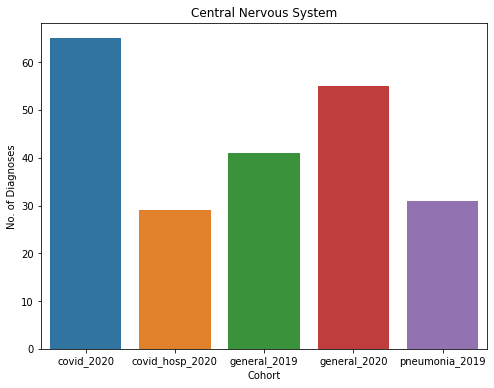

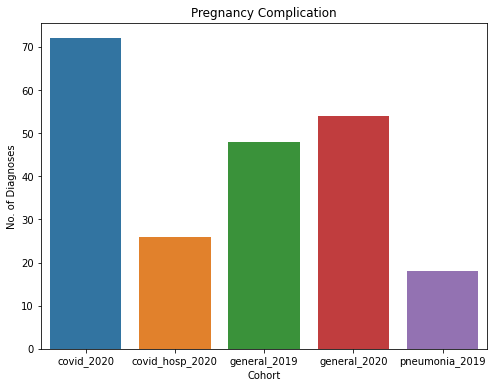

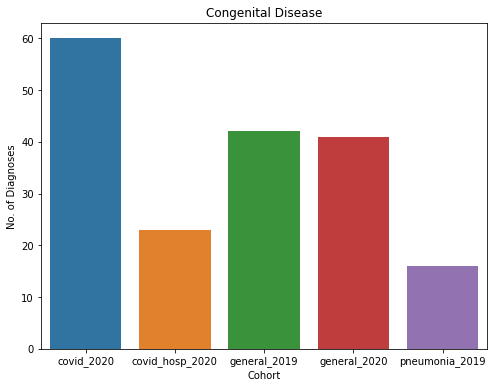

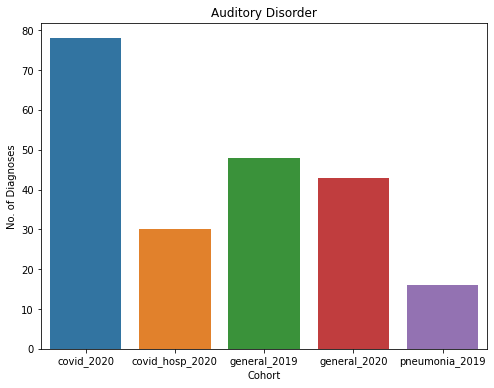

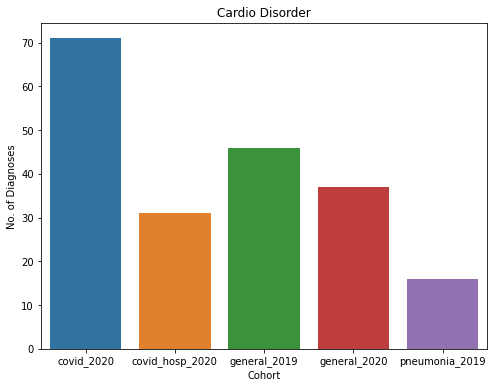

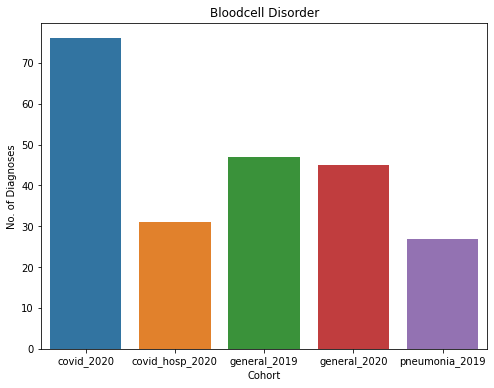

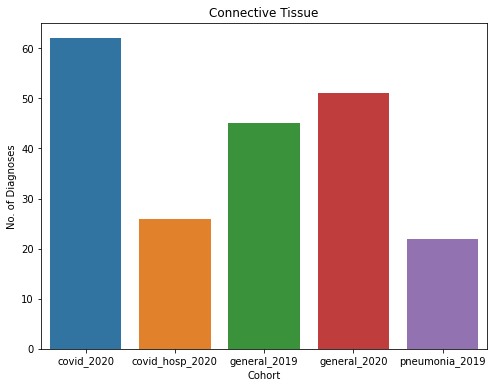

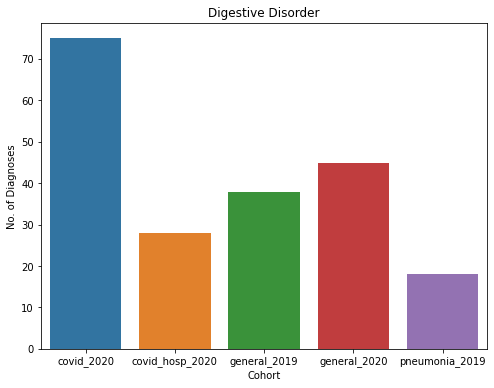

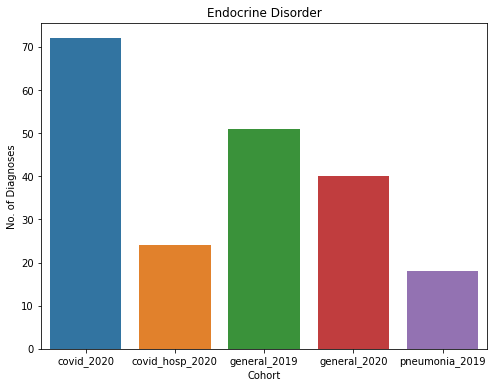

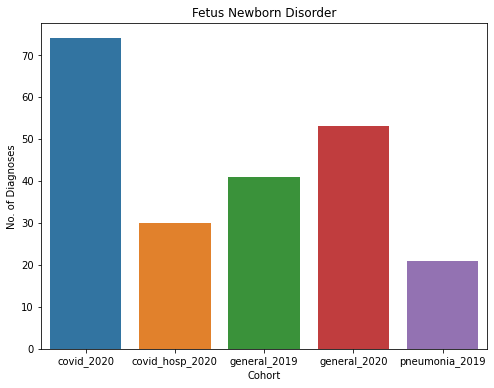

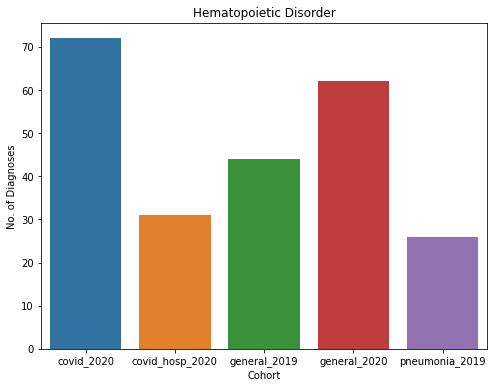

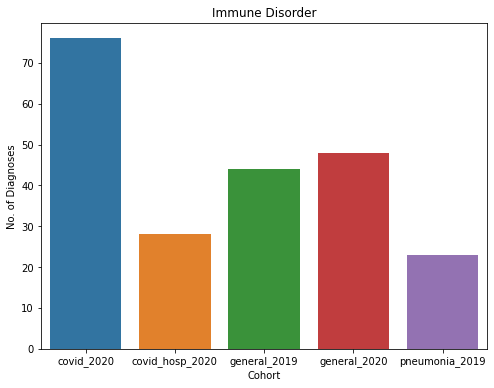

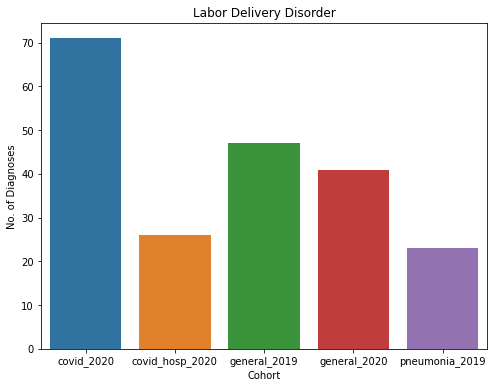

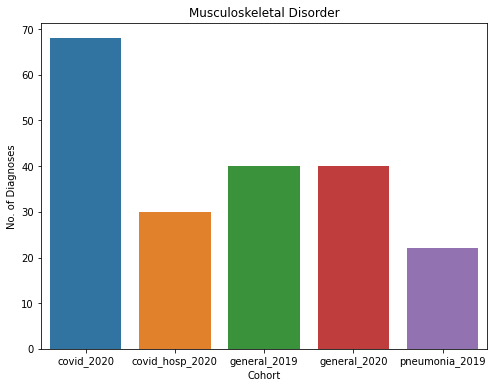

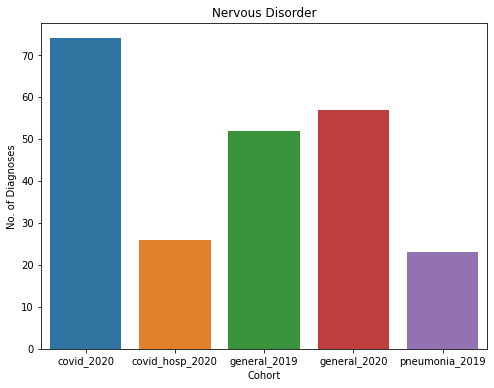

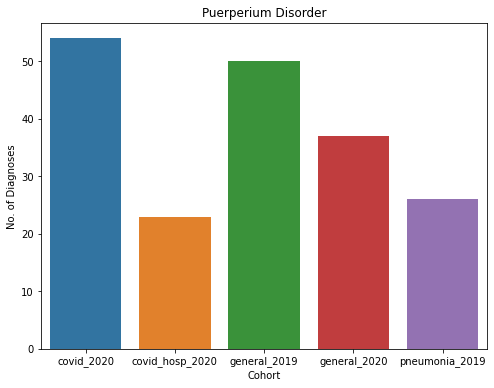

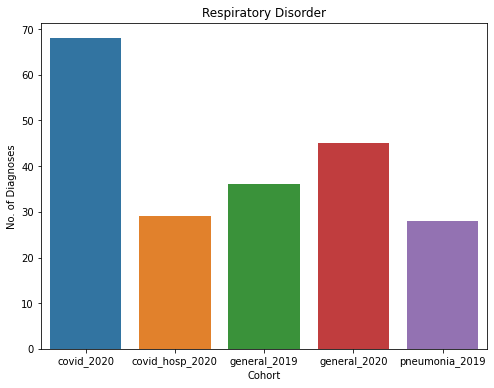

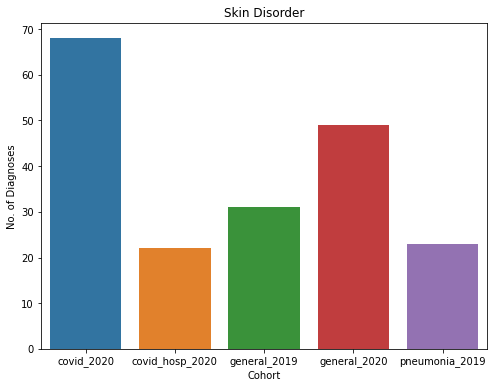

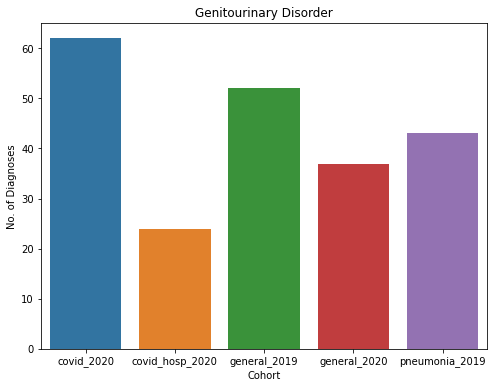

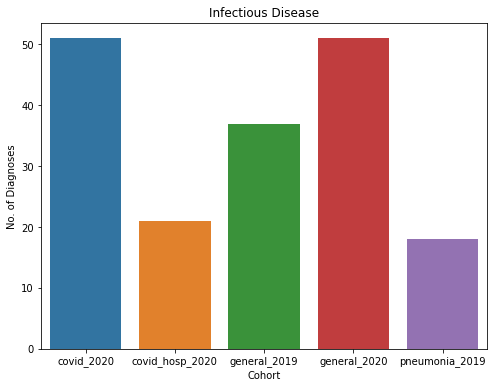

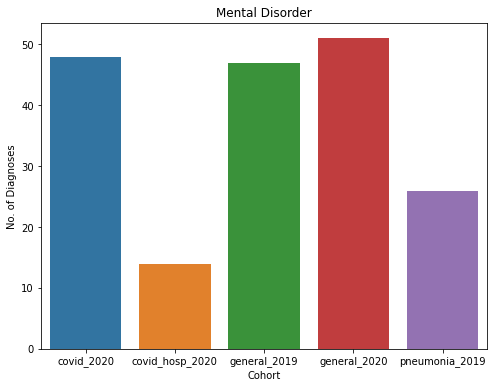

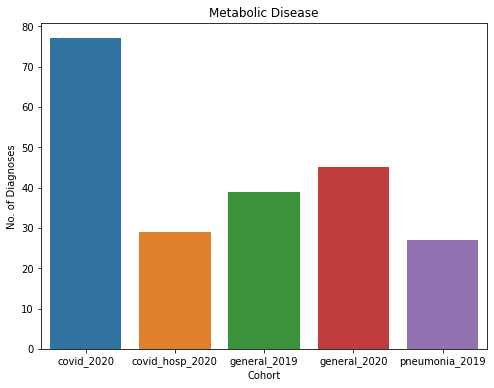

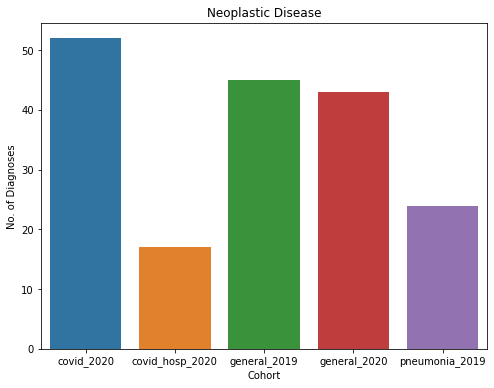

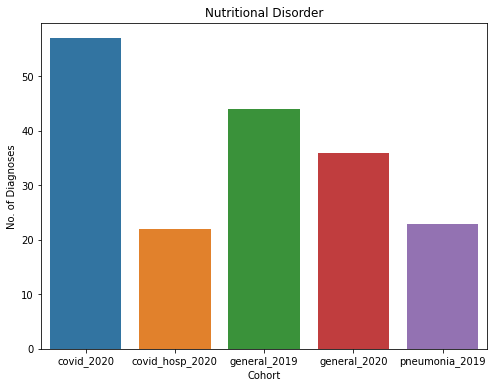

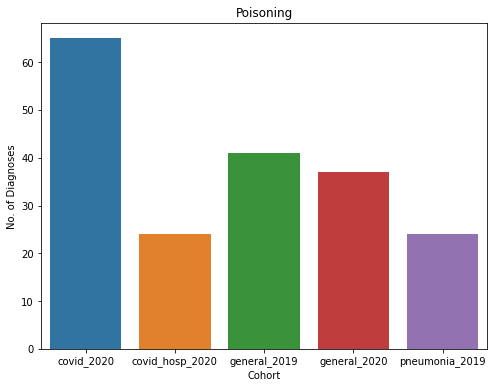

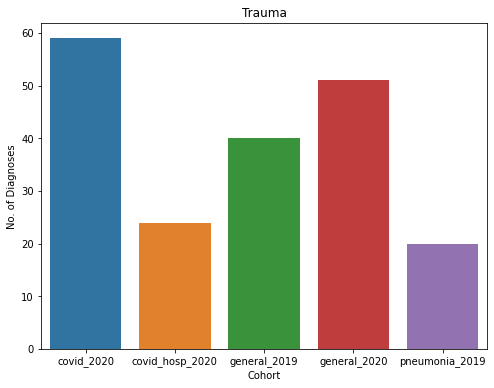

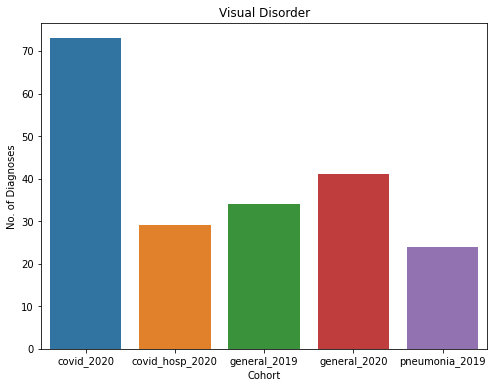

In [16]:
for c in num_diag_cols:
    create_plot(c, 'No. of Diagnoses')

### Proportion of Sick Notes by Diagnostic Category

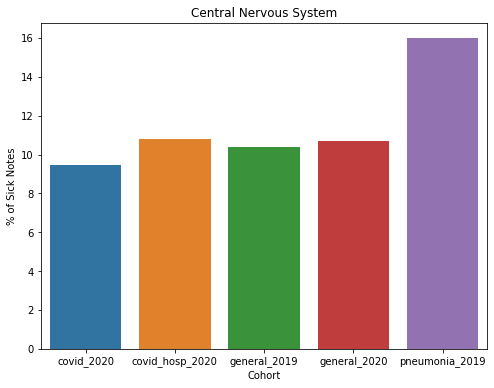

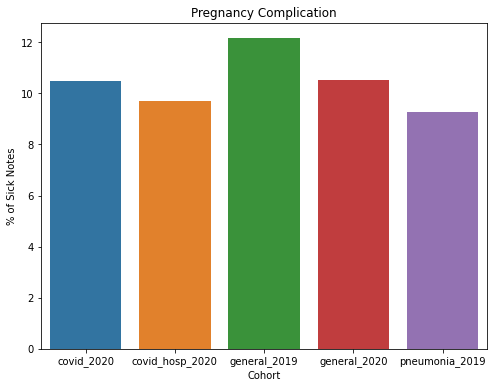

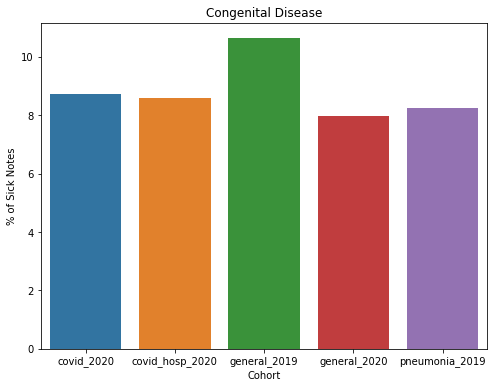

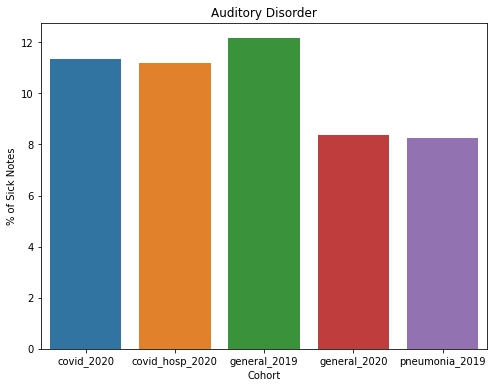

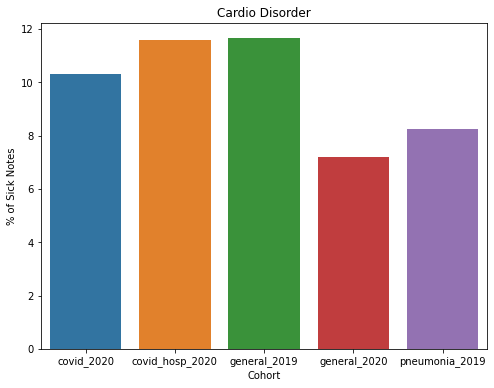

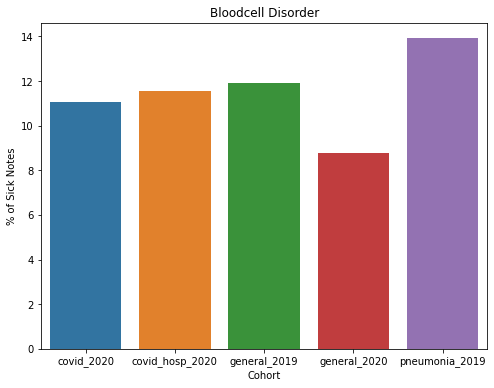

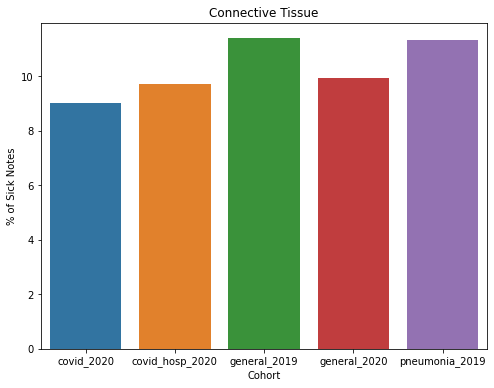

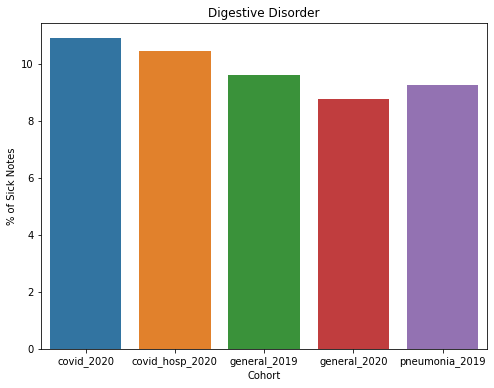

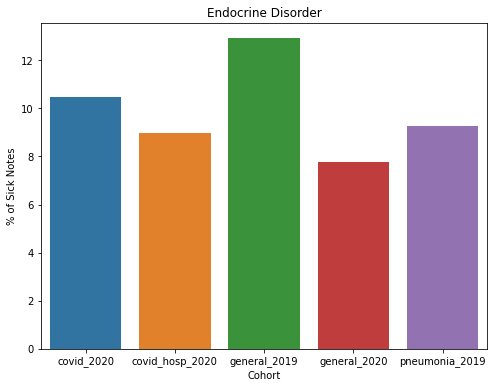

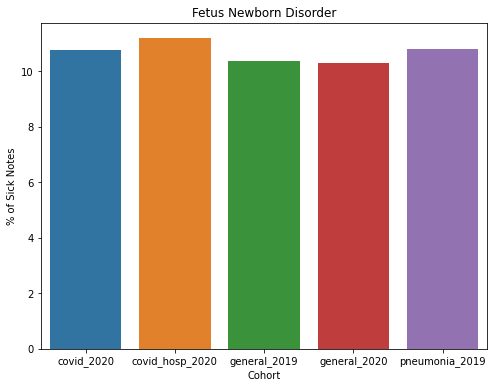

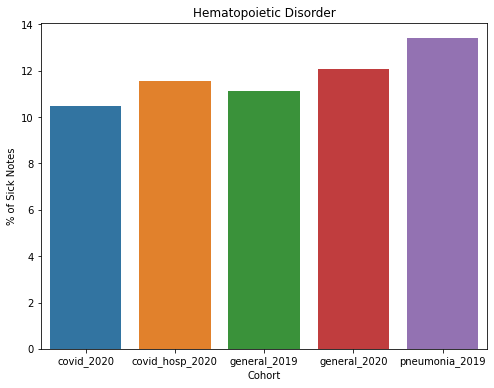

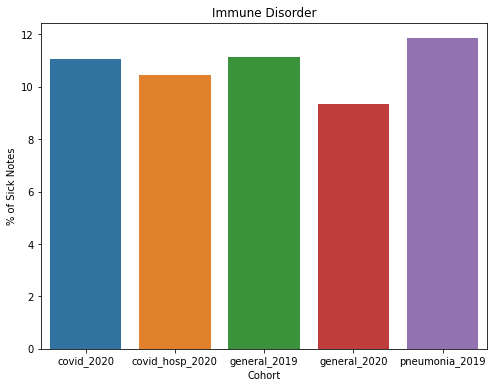

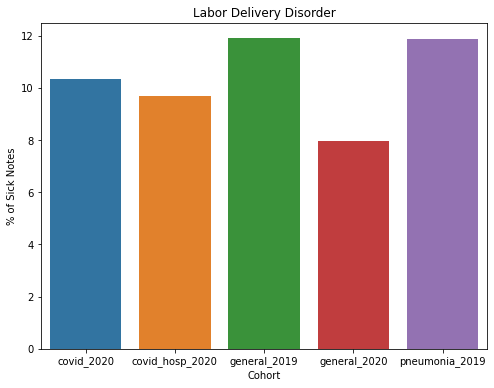

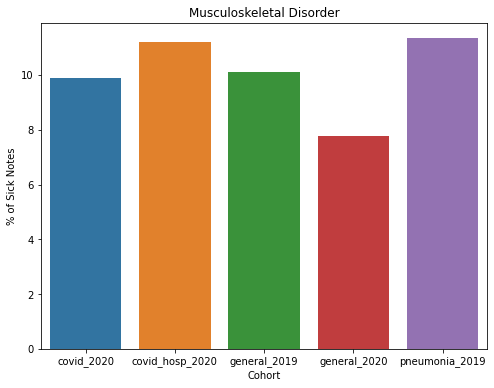

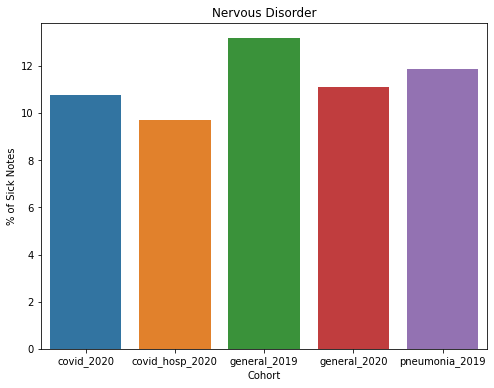

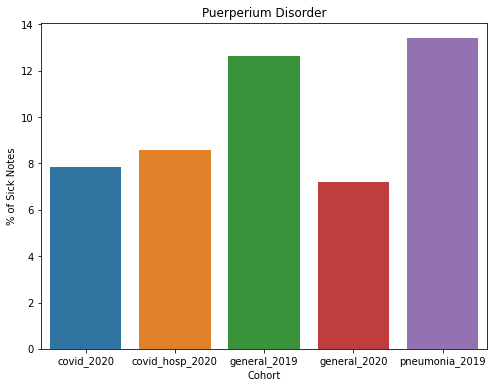

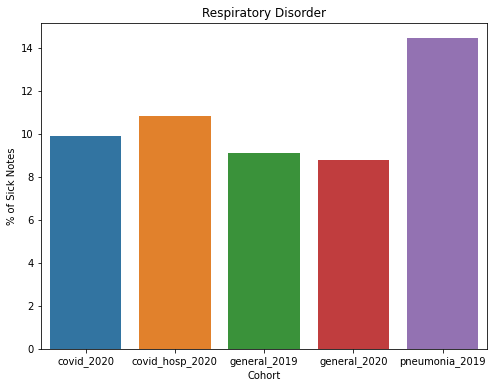

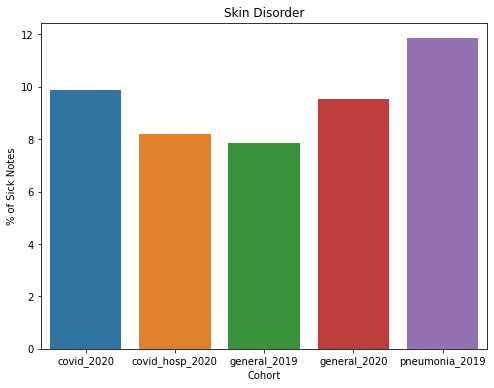

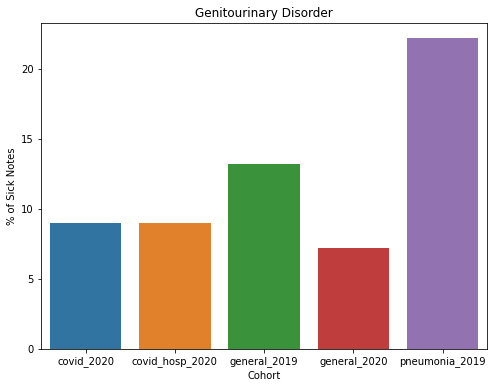

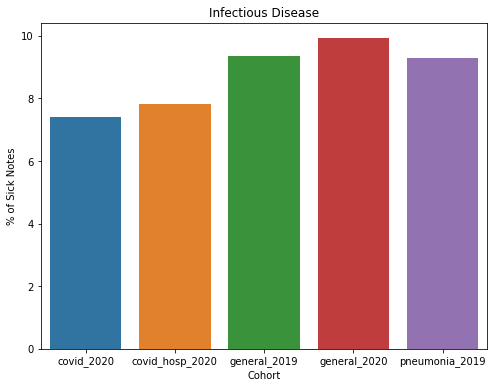

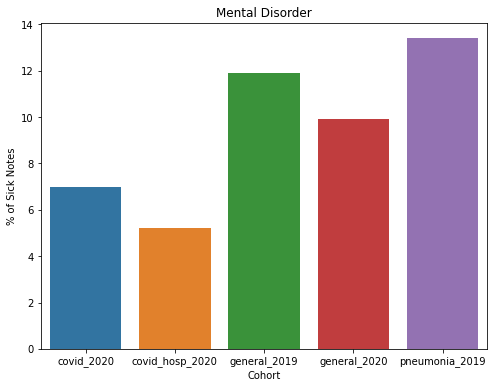

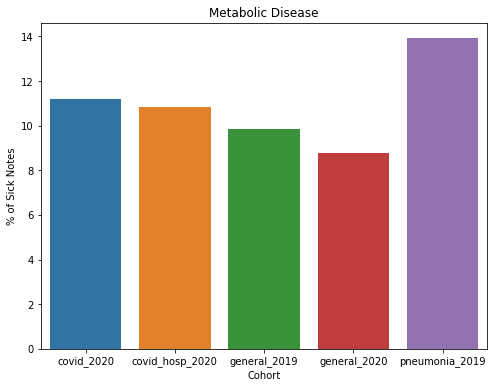

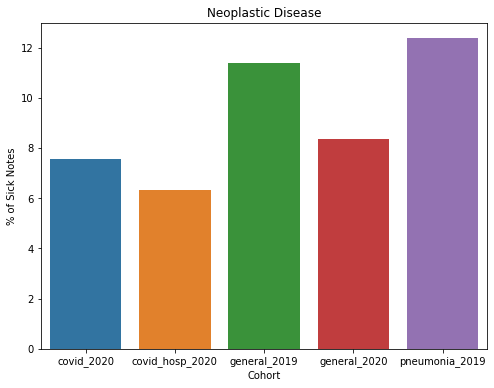

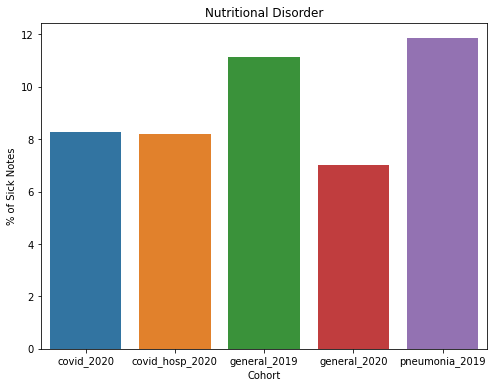

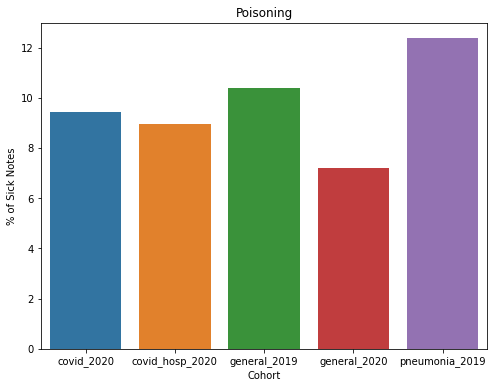

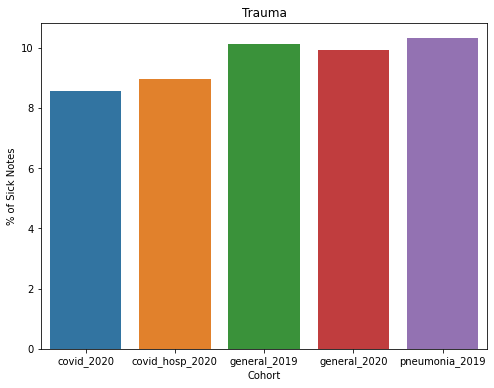

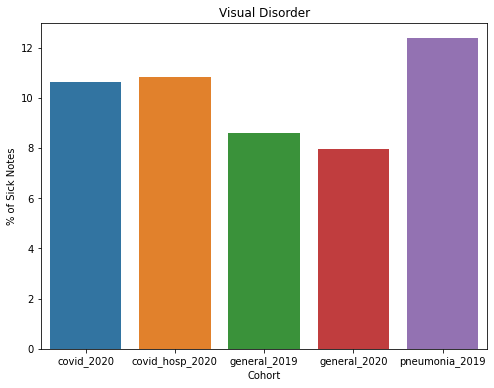

In [17]:
for c in pct_cols:
    create_plot(c, '% of Sick Notes')